In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ddos-evaluation-dataset-cic-ddos2019/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
class DDoSAnalysis:
    def __init__(self, file_path):
        self.raw_data = pd.read_csv(file_path)
        self.processed_data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def extensive_eda(self):
        # Dataset Overview
        print("Dataset Shape:", self.raw_data.shape)
        print("\nColumns:", list(self.raw_data.columns))
        print("\nMissing Values:\n", self.raw_data.isnull().sum())
        print("\nData Types:\n", self.raw_data.dtypes)
        
        # Replace Invalid Numeric Values
        numeric_cols = self.raw_data.select_dtypes(include=[np.number]).columns
        clean_numeric_data = self.raw_data[numeric_cols].replace([np.inf, -np.inf], np.nan).dropna()
        
        # 1. Missing Values Bar Plot
        missing_values = self.raw_data.isnull().sum()
        if missing_values.any():
            missing_values = missing_values[missing_values > 0]
            plt.figure(figsize=(5, 3))  # Create a new figure for this plot
            plt.bar(missing_values.index, missing_values.values, color='purple')
            plt.title('Missing Values per Column')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()  # Show the plot separately
        else:
            print("No Missing Values Detected.")
        
        # 2. Numeric Feature Distribution (Four Features per Plot)
        if not clean_numeric_data.empty:
            num_features = clean_numeric_data.columns
            num_plots = (len(num_features) + 3) // 4  # Calculate the number of plots needed
            for i in range(num_plots):
                start_index = i * 4
                end_index = min(start_index + 4, len(num_features))
        
                fig, axes = plt.subplots(2, 2, figsize=(12, 10))
                axes = axes.flatten()
        
                for j in range(4):
                    feature_index = start_index + j
                    if feature_index < len(num_features):
                        feature = num_features[feature_index]
                        axes[j].hist(clean_numeric_data[feature], bins=20, color='skyblue', edgecolor='black')
                        axes[j].set_title(f'{feature} Distribution')
                        axes[j].set_xlabel(f'{feature}')
                        axes[j].set_ylabel('Frequency')
                    else:
                        axes[j].axis('off')  # Hide unused subplots
            plt.figure(figsize=(10, 8))      
            plt.tight_layout()
            plt.show()
        else:
            print("No valid numeric data for distribution plot.")

        # # 3. Correlation Heatmap
        # if not clean_numeric_data.empty:
        #     plt.figure(figsize=(10, 8))  # Create a new figure for this plot
        #     corr_matrix = clean_numeric_data.corr()
        #     sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
        #     plt.title('Feature Correlation Heatmap')
        #     plt.tight_layout()
        #     plt.show()  # Show the plot separately
        # else:
        #     print("No valid numeric data for correlation heatmap.")
        
        # 4. Boxplots for Outlier Detection
        if not clean_numeric_data.empty:
            plt.figure(figsize=(30, 15))  # Create a new figure for this plot
            sns.boxplot(data=clean_numeric_data)
            plt.title('Boxplot of Numeric Features')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()  # Show the plot separately
        else:
            print("No valid numeric data for boxplot.")
        
        # 5. Target Variable Distribution
        if ' Label' in self.raw_data.columns:  # Ensure the target column exists
            plt.figure(figsize=(8, 8))  # Create a new figure for this plot
            self.raw_data[' Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
            plt.title('Label Distribution')
            plt.ylabel('')  # Remove y-axis label for better appearance
            plt.tight_layout()
            plt.show()  # Show the plot separately
        else:
            print("Target Column 'Label' Missing.")

    def preprocess_data(self, target_column=' Label', test_size=0.2):
        df = self.raw_data.copy()
        
        # Encode categorical columns
        categorical_cols = df.select_dtypes(include=['object']).columns
        label_encoder = LabelEncoder()
        for col in categorical_cols:
            df[col] = label_encoder.fit_transform(df[col].astype(str))
        
        # Remove irrelevant columns
        df = df.drop(['Timestamp'], axis=1, errors='ignore')
        
        # Separate features and target
        X = df.drop(columns=[target_column])
        y = df[target_column]
        
        # Check for NaN or infinite values in X
        if X.isnull().any().any() or np.isinf(X.values).any():
            print("Warning: NaN or Infinite values detected in the feature set. Handling them.")
            
            # Replace NaN with the column mean or median (you can choose your preferred method)
            X = X.fillna(X.mean())
            
            # Replace infinite values with a large finite number (e.g., max value)
            X = X.replace([np.inf, -np.inf], X.max().max())
            
            # Optionally: Clip extreme values to avoid any overflows
            # This could be based on a predefined upper and lower bound, for example:
            lower_bound = -1e6
            upper_bound = 1e6
            X = X.clip(lower=lower_bound, upper=upper_bound)
    
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
        
        # Scale features
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.transform(self.X_test)
        
        self.processed_data = df

    def feature_importance(self, n_features=10):
        selector = SelectKBest(score_func=f_classif, k=n_features)
        X_new = selector.fit_transform(self.X_train, self.y_train)

        feature_names = self.processed_data.drop(columns=[' Label']).columns
        selected_features = feature_names[selector.get_support()]

        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_classifier.fit(self.X_train, self.y_train)

        feature_imp = pd.DataFrame({
            'feature': selected_features,
            'importance': rf_classifier.feature_importances_[:len(selected_features)]
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_imp)
        plt.title(f'Top {n_features} Most Important Features')
        plt.tight_layout()
        plt.show()

        return feature_imp

    def train_ml_models(self):
        models = {
            'SVM': {
                'model': SVC(),
                'params': {
                    'C': [0.1, 1, 10],
                    'kernel': ['linear', 'rbf']
                }
            },
            'Random Forest': {
                'model': RandomForestClassifier(),
                'params': {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [None, 10, 20, 30]
                }
            },
            'XGBoost': {
                'model': XGBClassifier(),
                'params': {
                    'learning_rate': [0.01, 0.1, 0.5],
                    'n_estimators': [50, 100, 200]
                }
            }
        }

        results = {}
        for name, setup in models.items():
            grid_search = GridSearchCV(
                estimator=setup['model'], 
                param_grid=setup['params'], 
                cv=5, 
                scoring='f1', 
                n_jobs=-1
            )
            
            grid_search.fit(self.X_train, self.y_train)
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(self.X_test)
            
            results[name] = {
                'best_params': grid_search.best_params_,
                'classification_report': classification_report(self.y_test, y_pred),
                'confusion_matrix': confusion_matrix(self.y_test, y_pred),
                'accuracy': accuracy_score(self.y_test, y_pred)
            }
        
        return results

    def deep_learning_model(self):
        X_train = self.X_train
        X_test = self.X_test
        y_train = tf.keras.utils.to_categorical(self.y_train)
        y_test = tf.keras.utils.to_categorical(self.y_test)

        def create_model(learning_rate=0.001, units1=64, units2=32, dropout_rate=0.3):
            model = Sequential([
                Dense(units1, activation='relu', input_shape=(X_train.shape[1],)),
                BatchNormalization(),
                Dropout(dropout_rate),
                Dense(units2, activation='relu'),
                BatchNormalization(),
                Dropout(dropout_rate),
                Dense(y_train.shape[1], activation='softmax')
            ])
            
            optimizer = Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, 
                          loss='categorical_crossentropy', 
                          metrics=['accuracy'])
            return model

        early_stopping = EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=5, 
            min_lr=0.00001
        )

        model = create_model()
        history = model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test, axis=1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        return {
            'classification_report': classification_report(y_test_classes, y_pred_classes),
            'confusion_matrix': confusion_matrix(y_test_classes, y_pred_classes),
            'accuracy': accuracy_score(y_test_classes, y_pred_classes)
        }


In [4]:
# Initialize the class with the dataset path
ddos_analysis = DDoSAnalysis('/kaggle/input/ddos-evaluation-dataset-cic-ddos2019/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

Performing Extensive EDA...
Dataset Shape: (225745, 85)

Columns: ['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', '

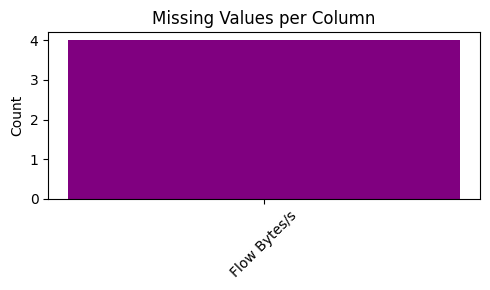

/tmp/ipykernel_80/1924961182.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))


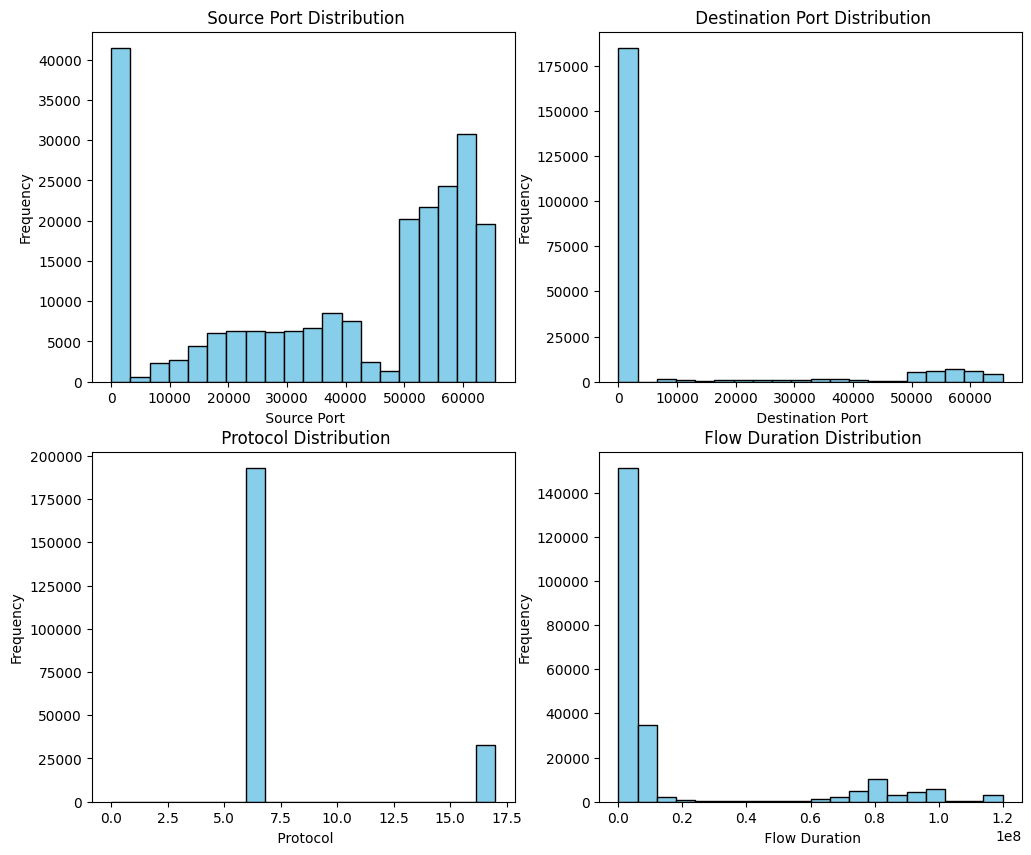

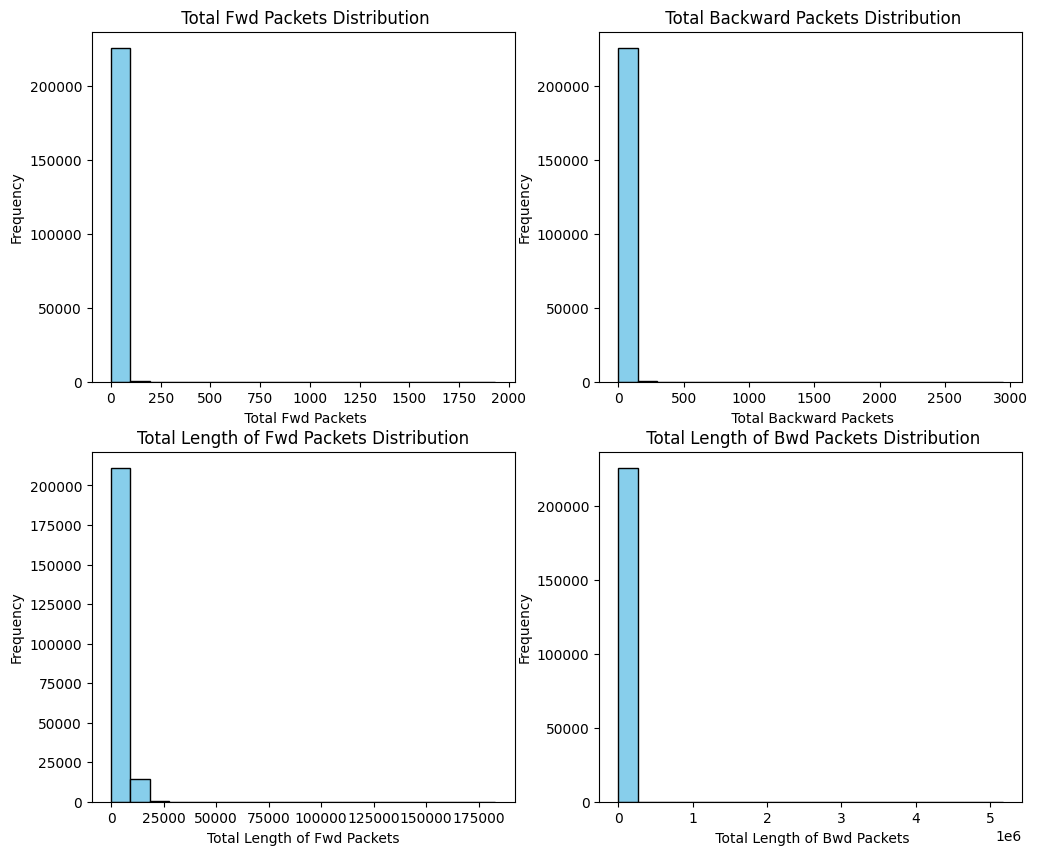

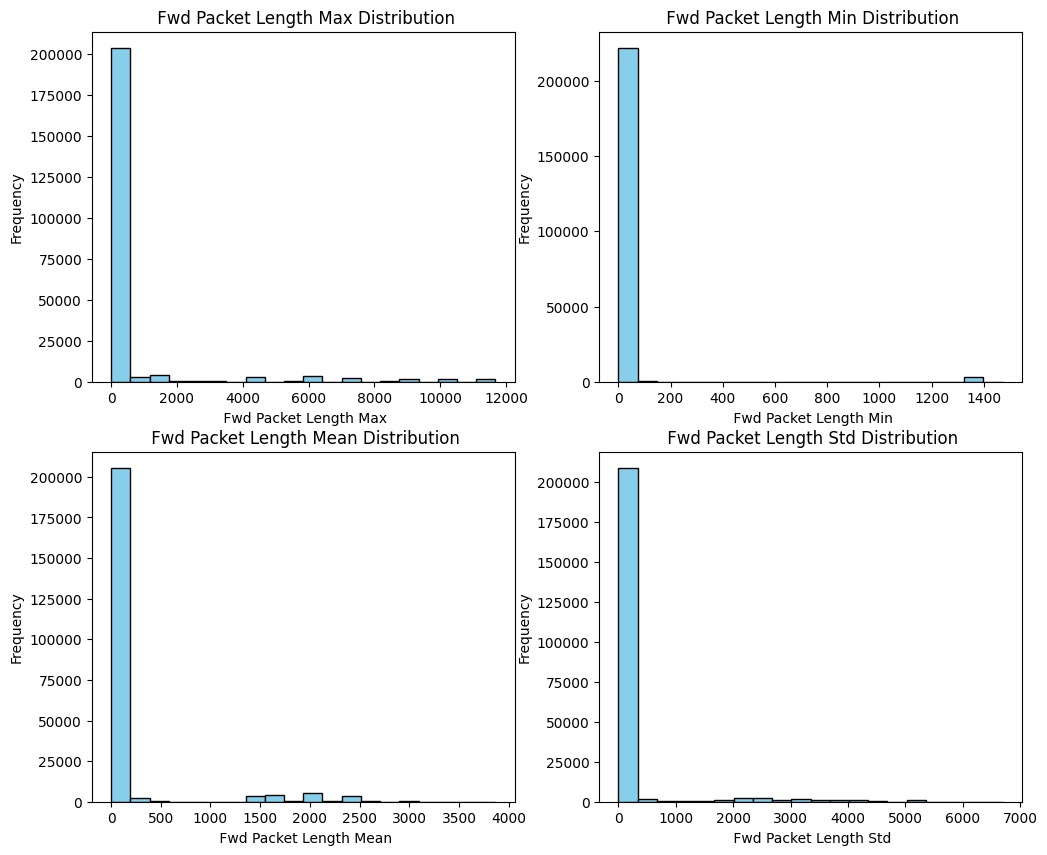

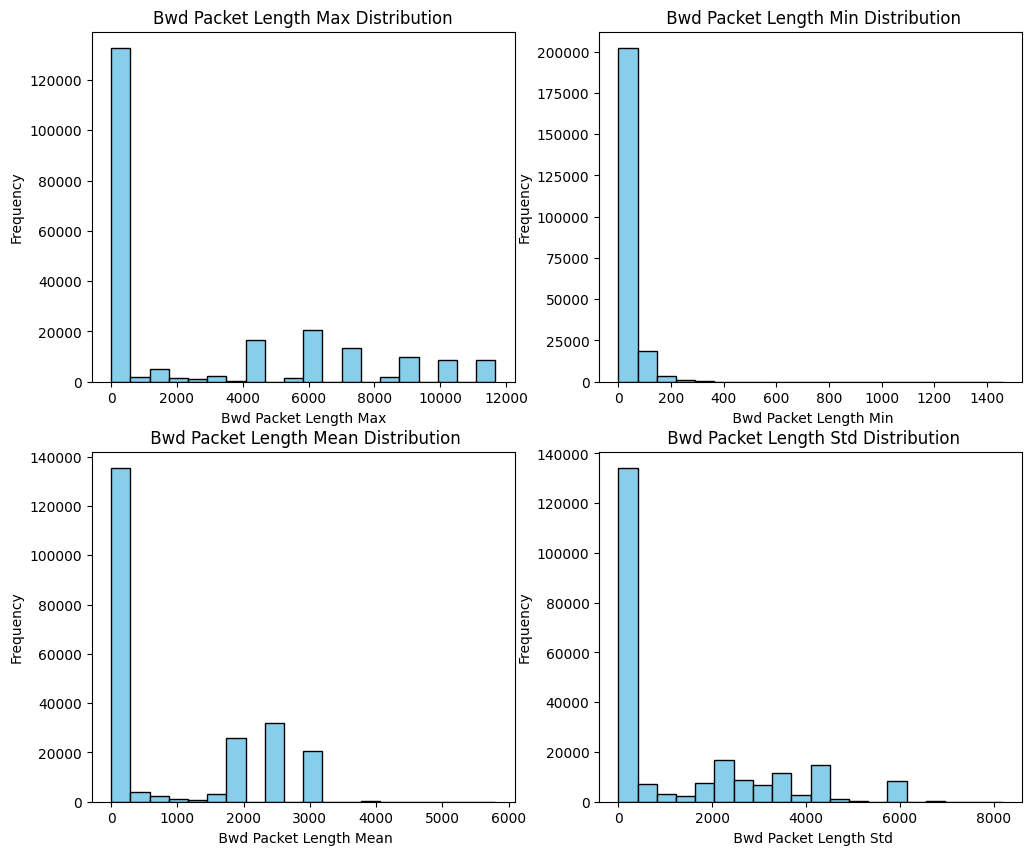

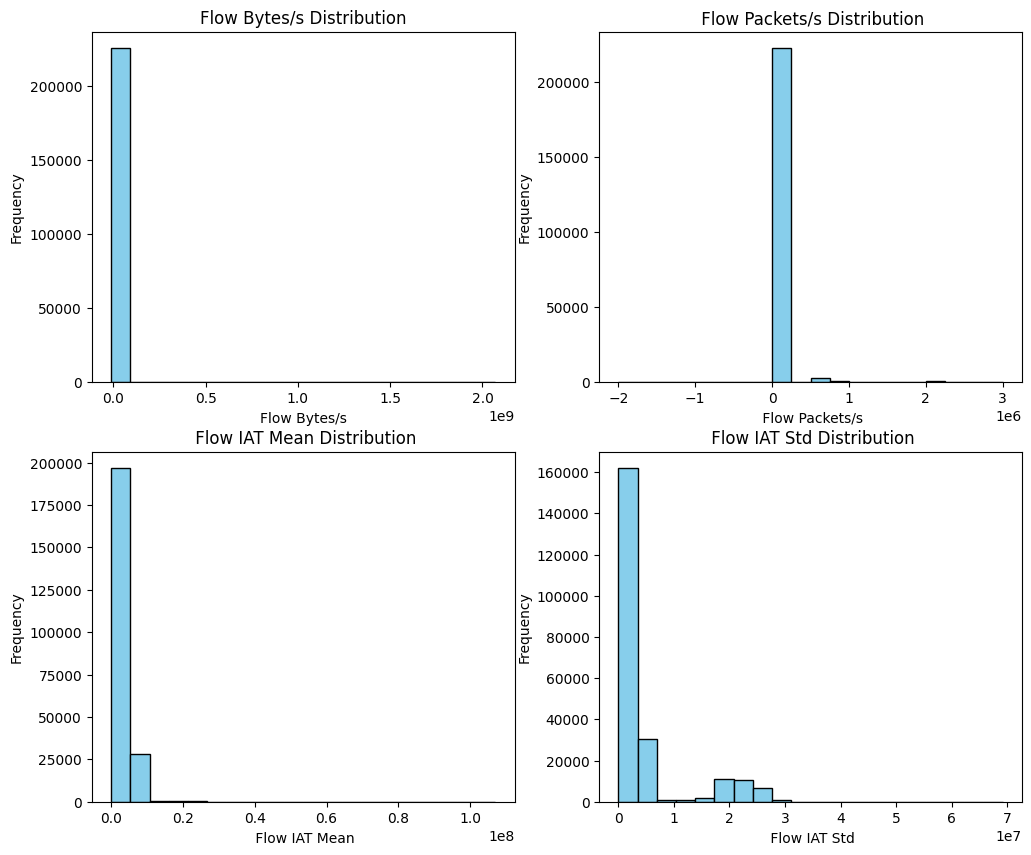

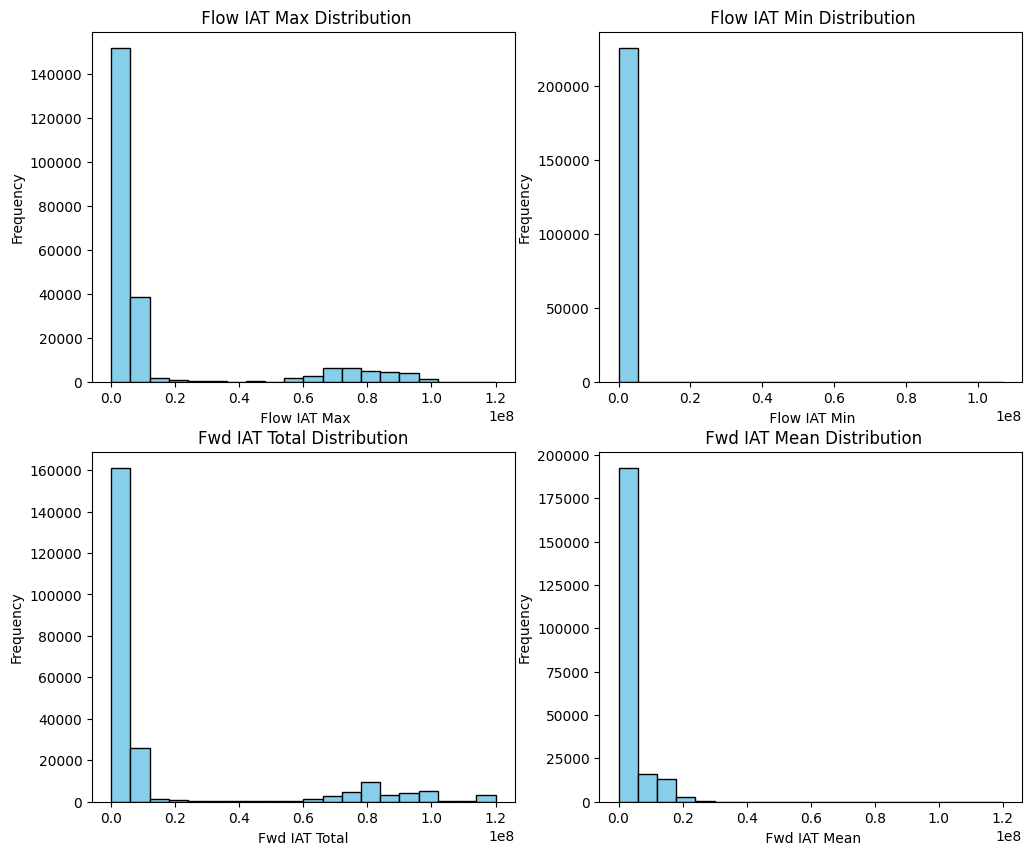

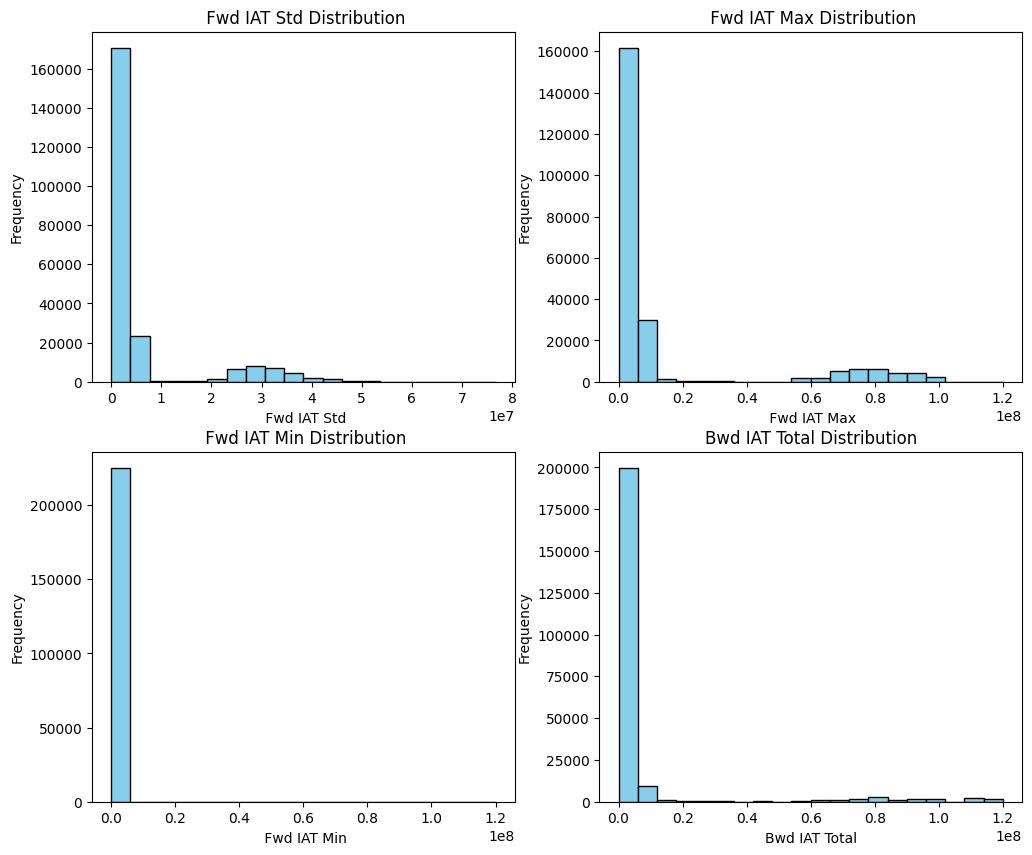

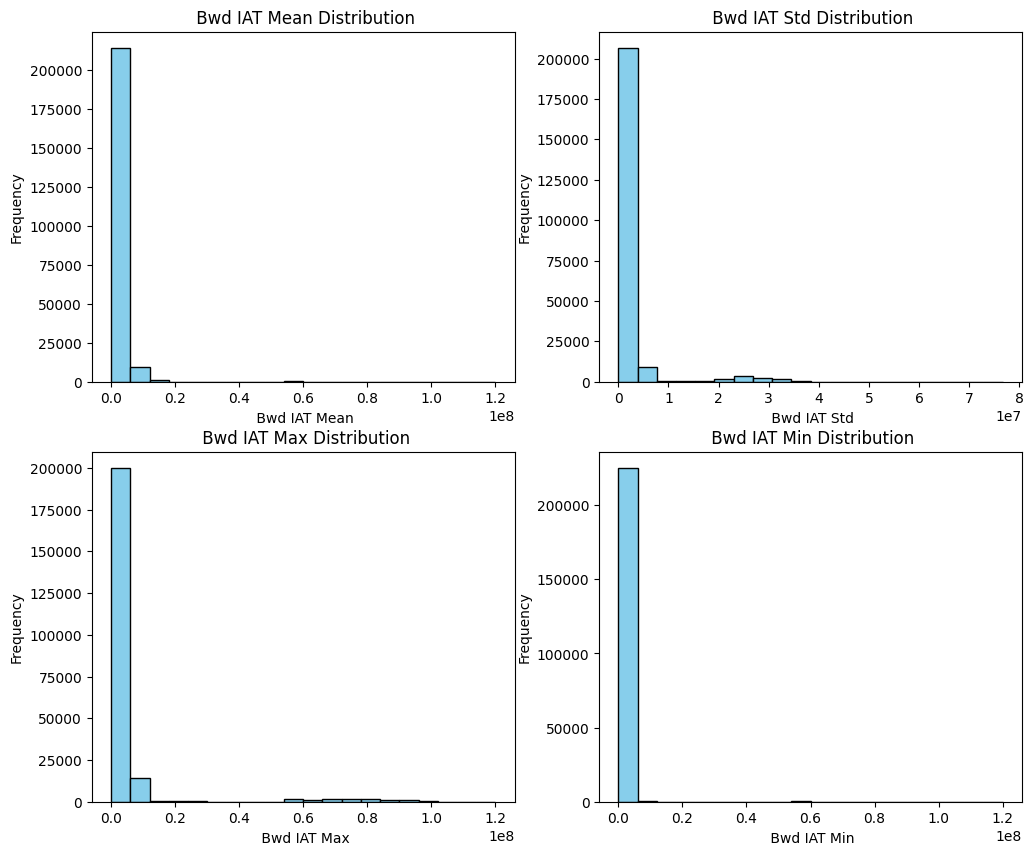

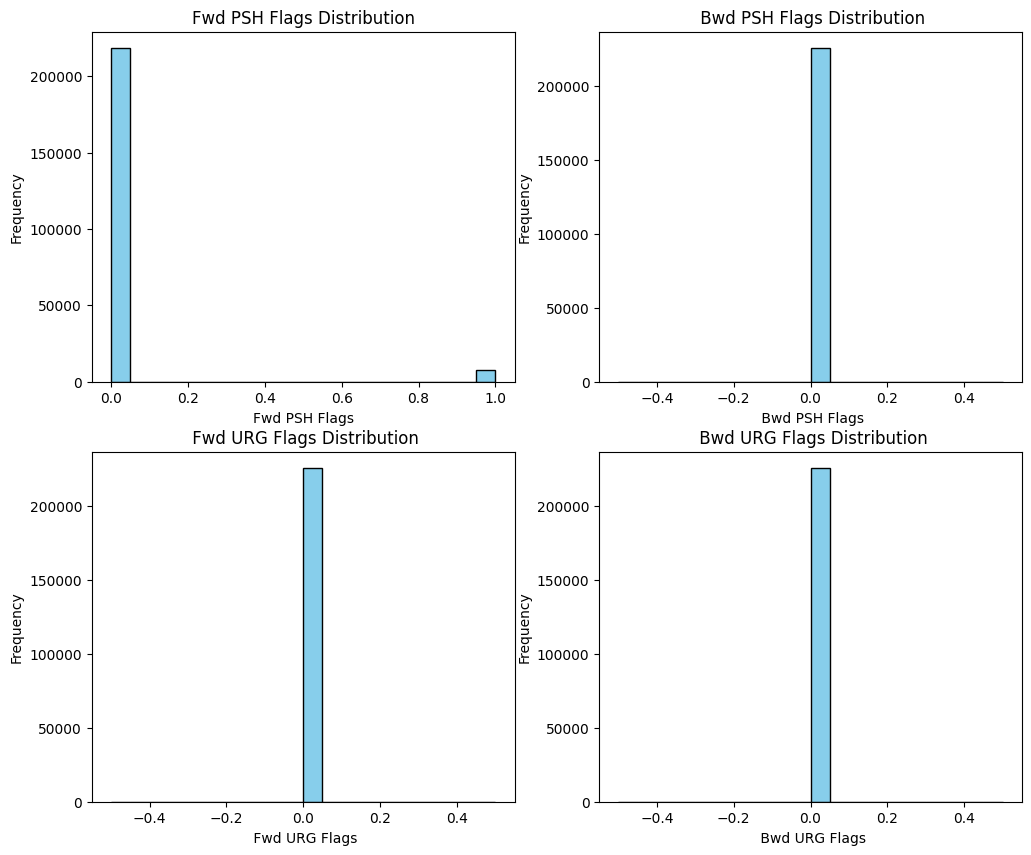

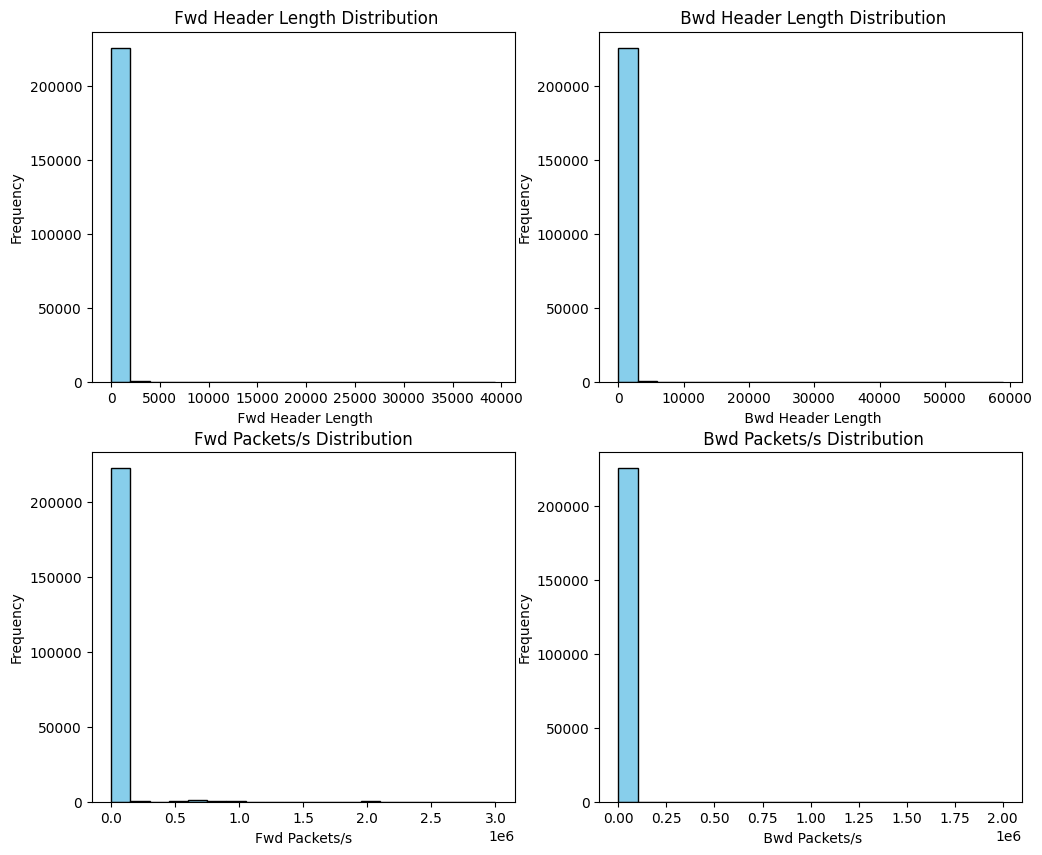

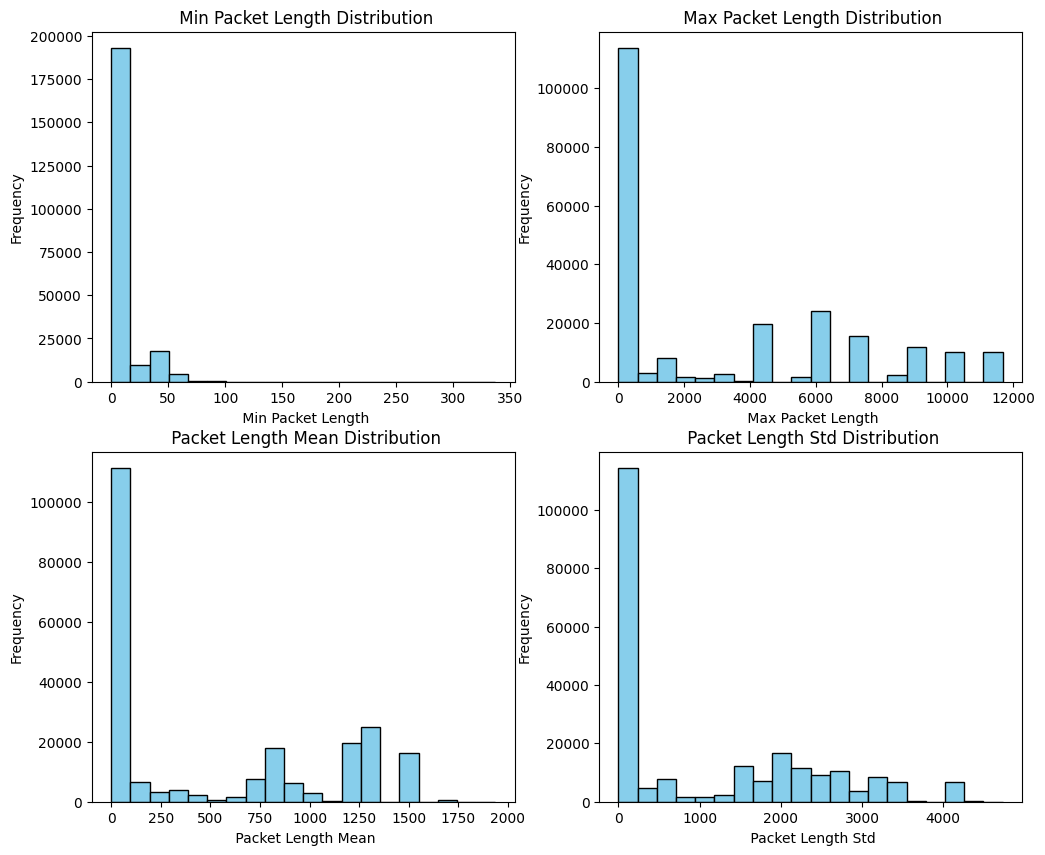

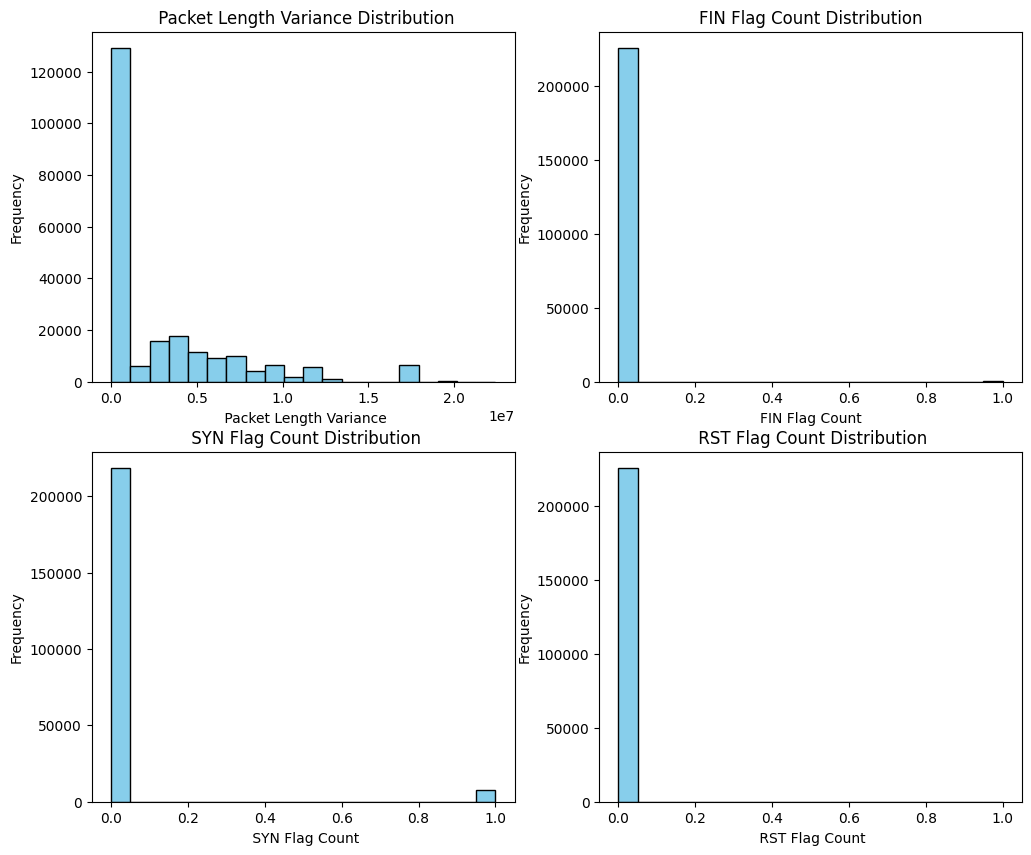

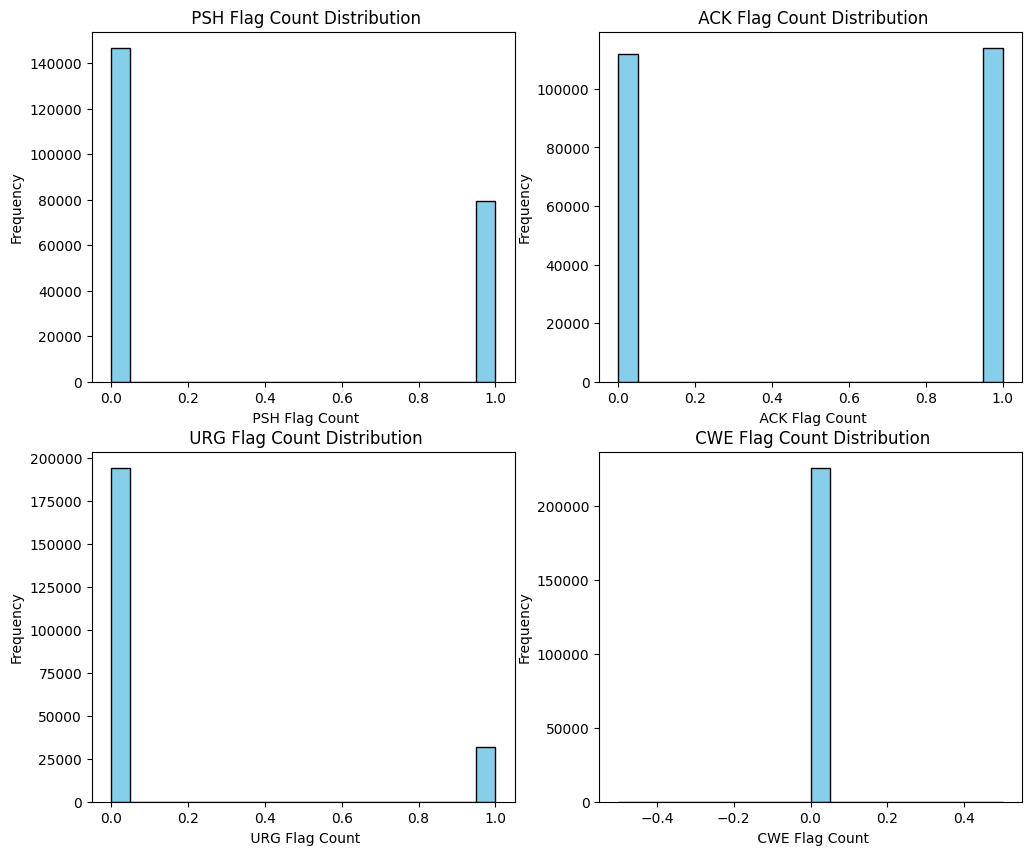

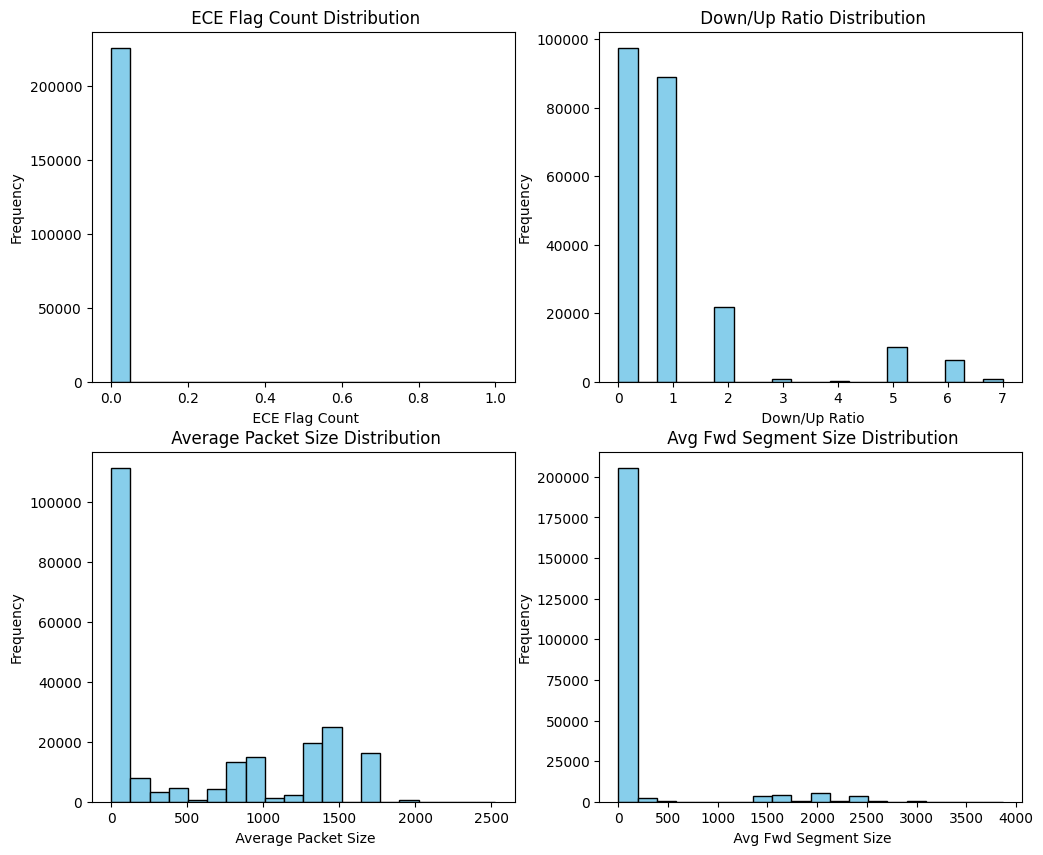

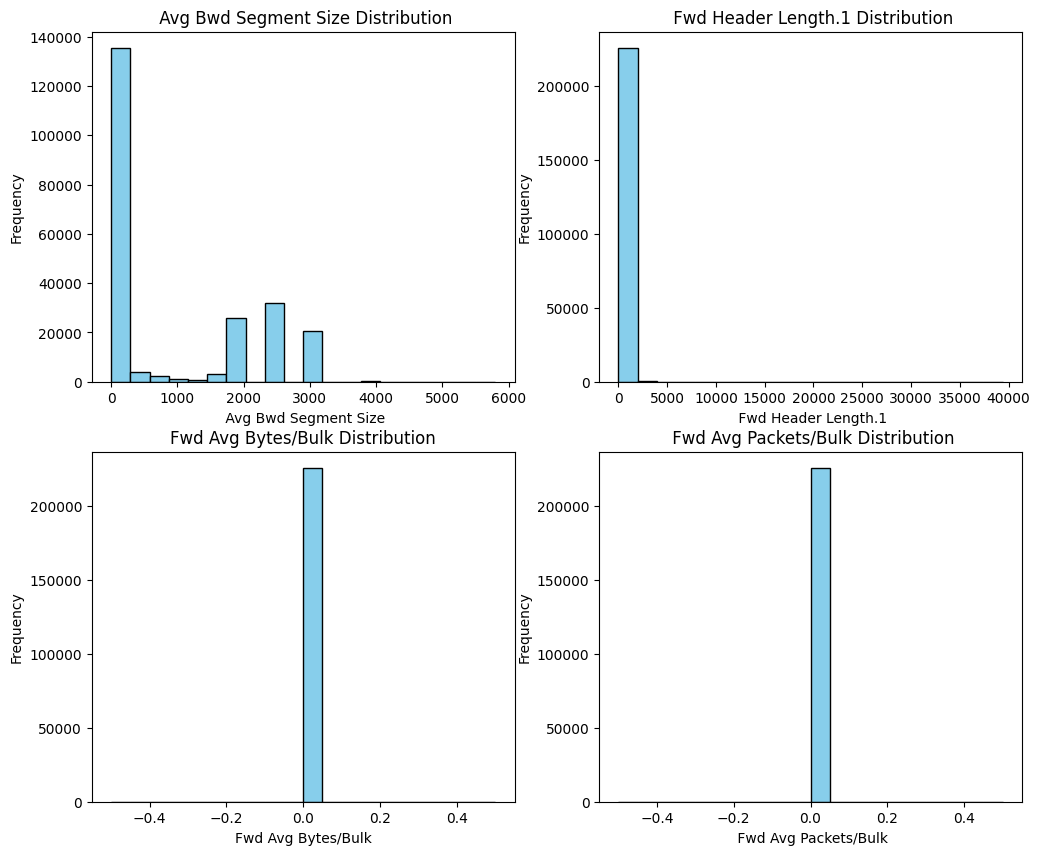

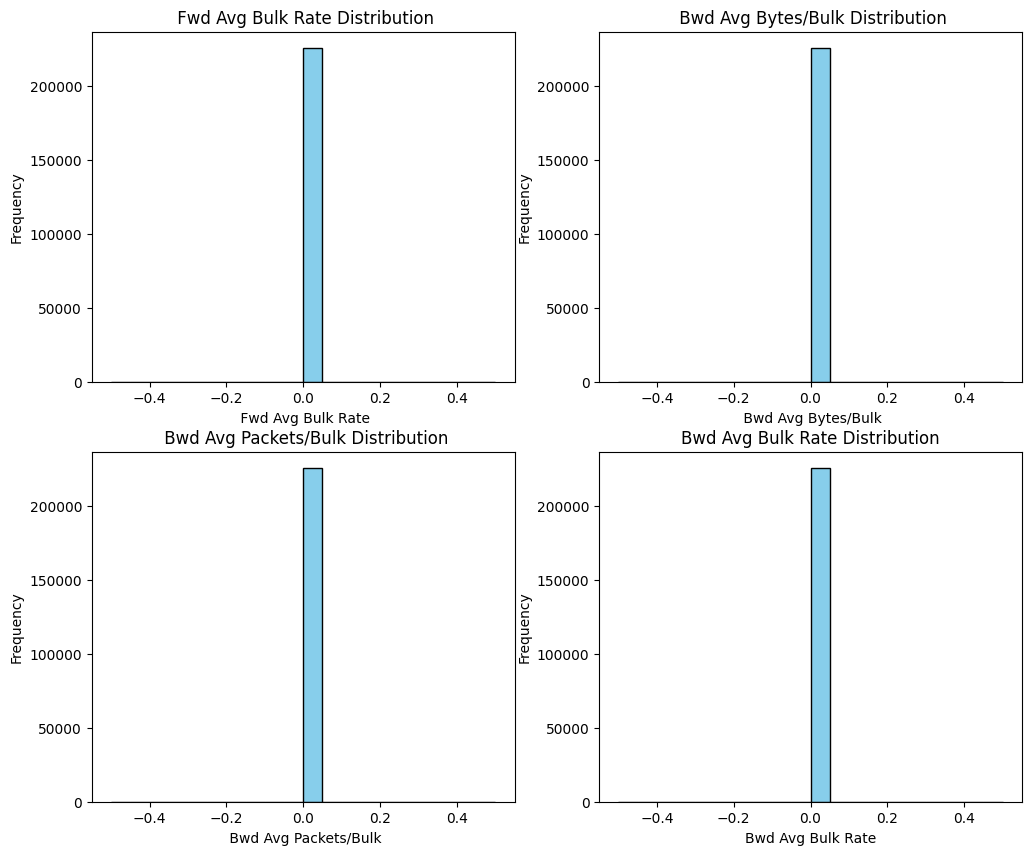

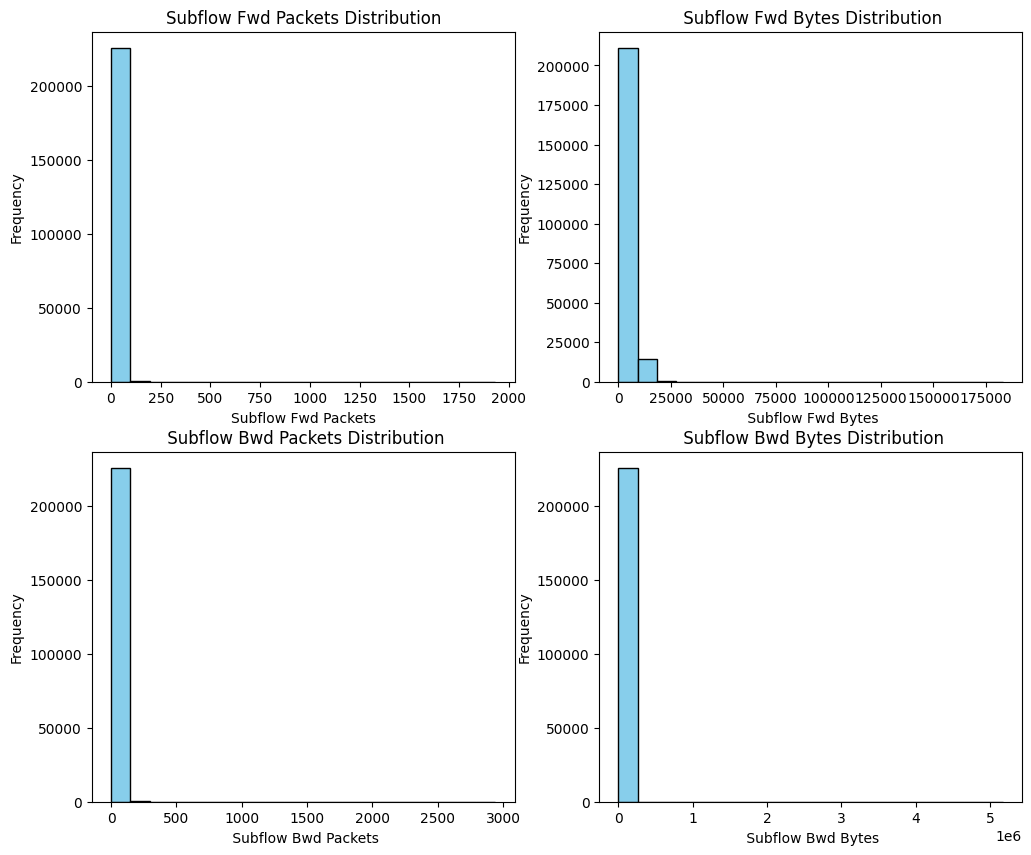

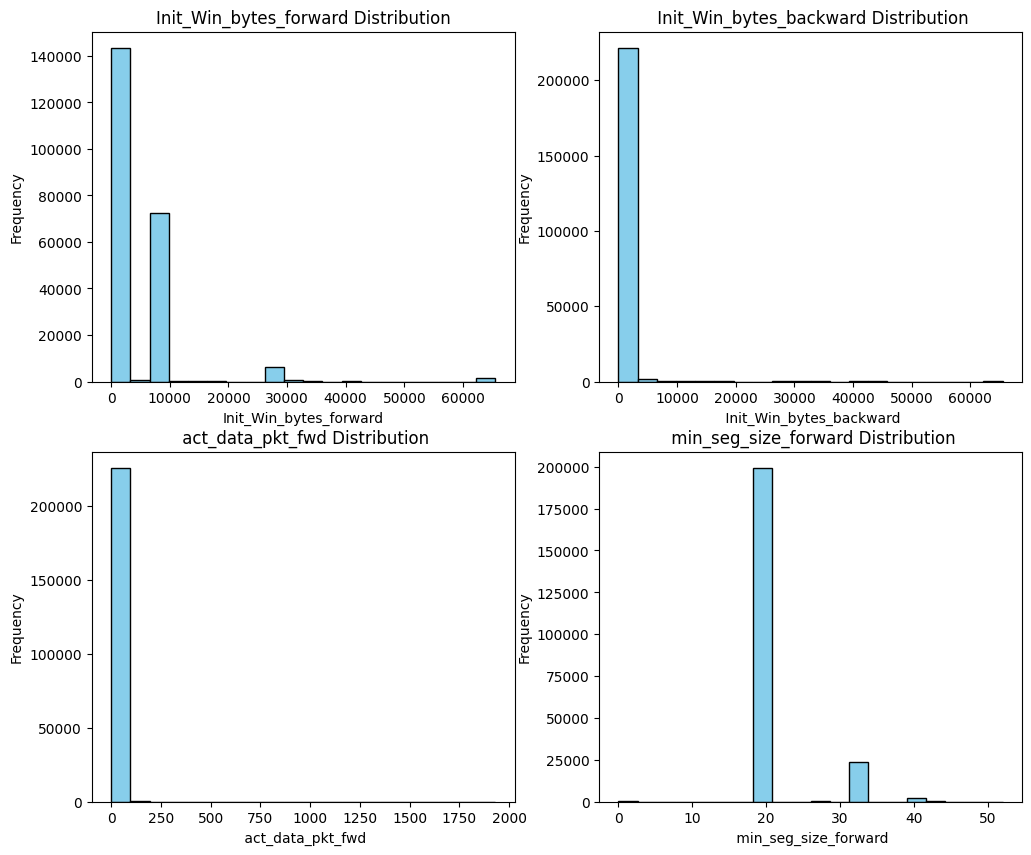

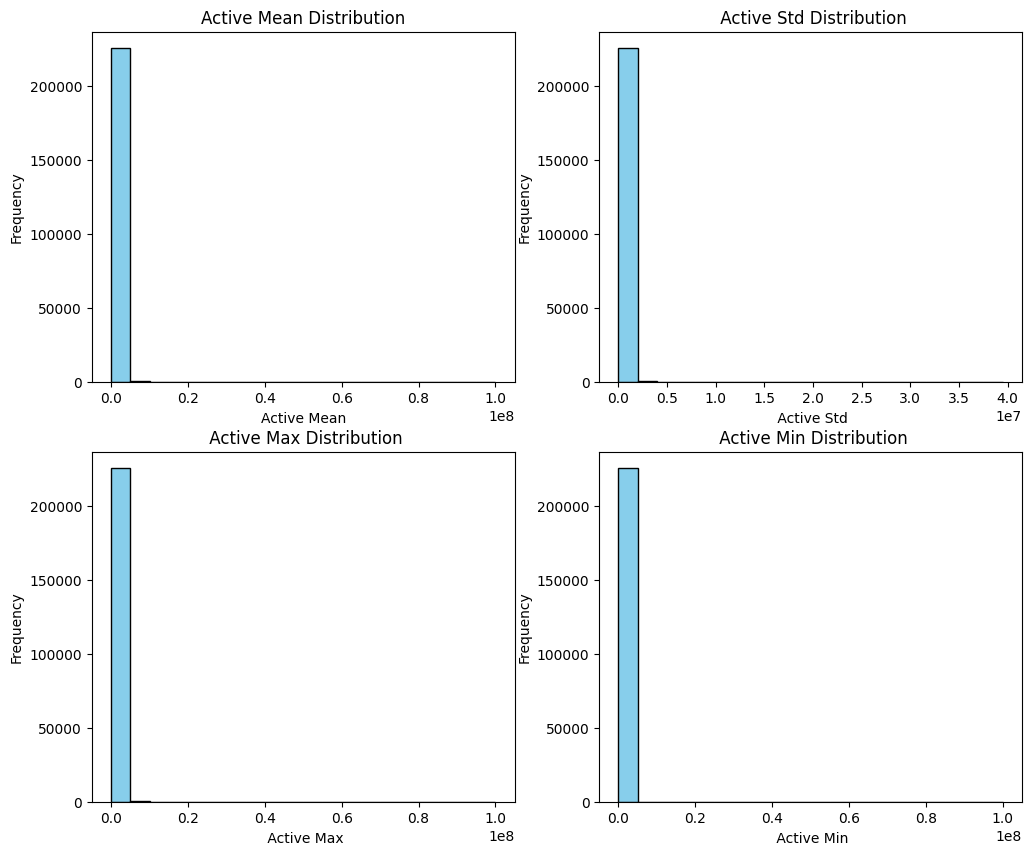

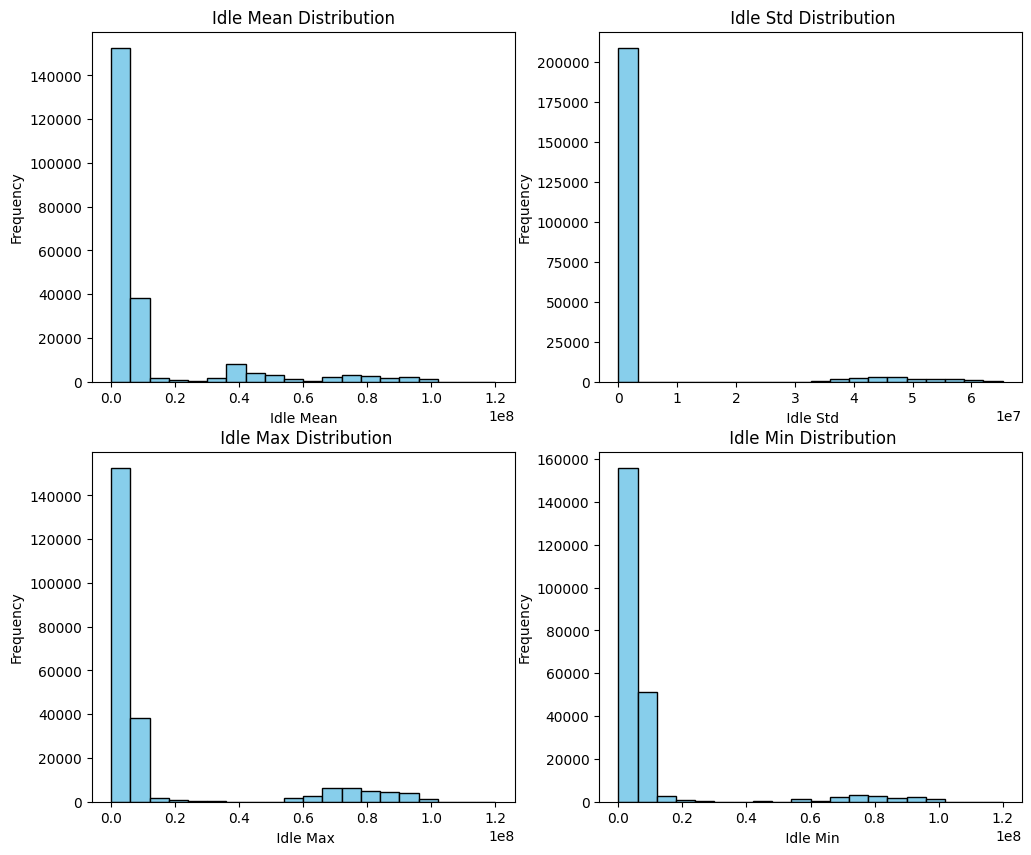

<Figure size 1000x800 with 0 Axes>

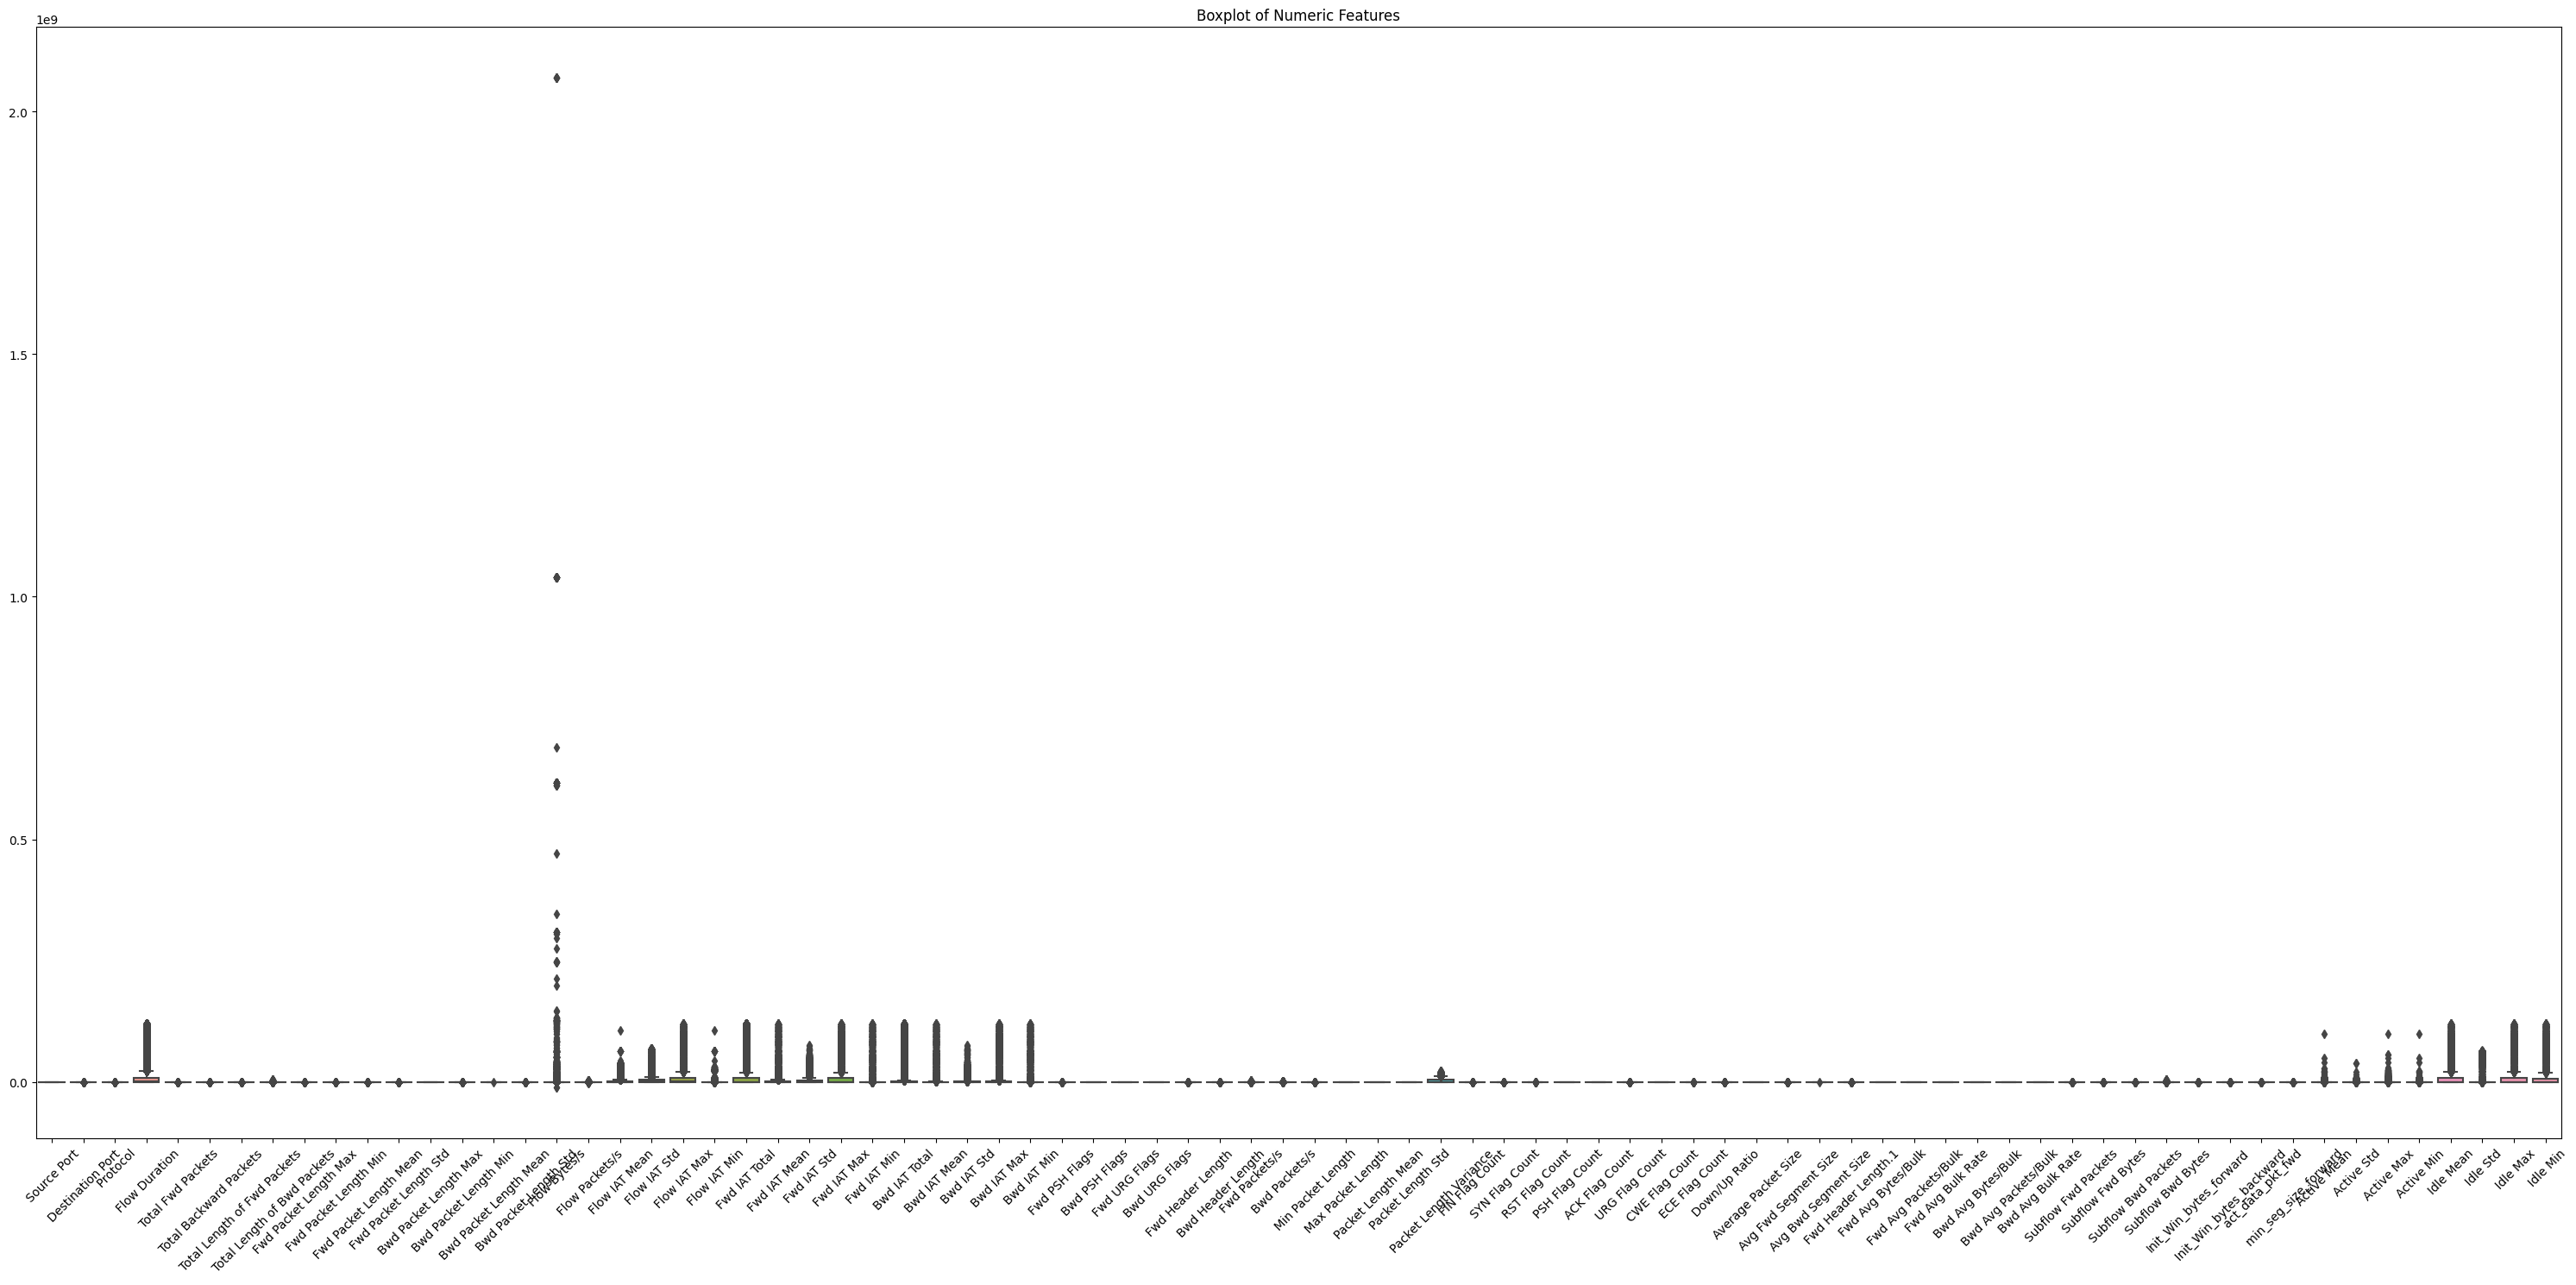

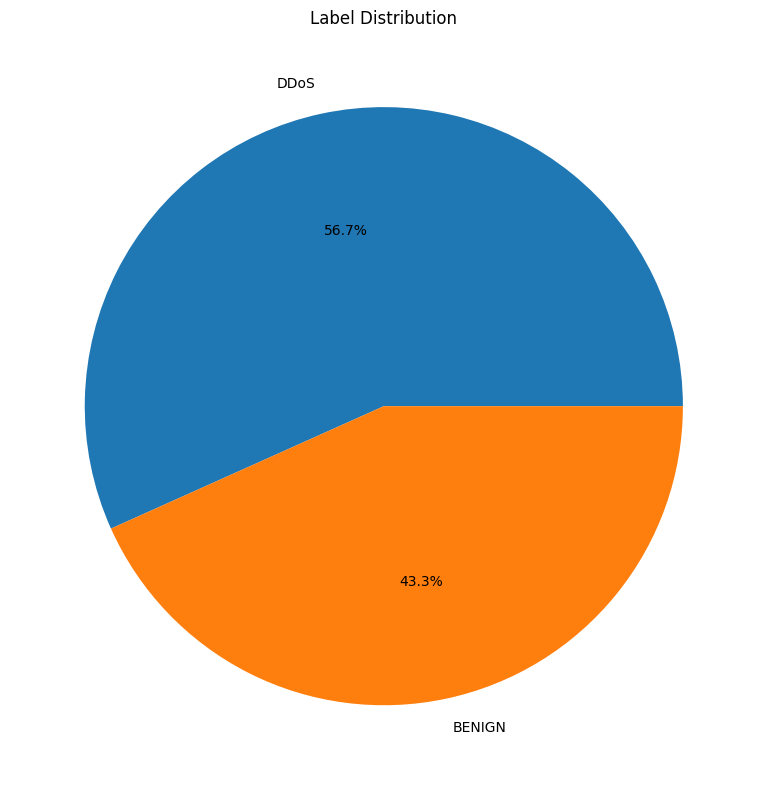

In [5]:
# Perform EDA
print("Performing Extensive EDA...")
ddos_analysis.extensive_eda()

In [6]:
# Preprocess Data
print("\nPreprocessing Data...")
ddos_analysis.preprocess_data()


Preprocessing Data...



Feature Importance Analysis...


/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [37 38 39 55 62 63 64 65 66 67] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


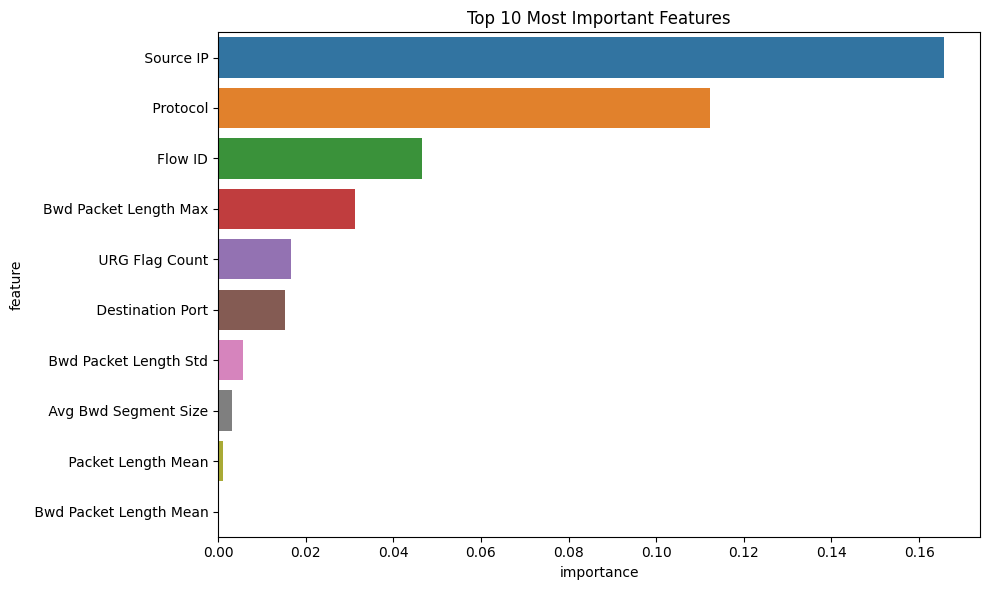

,feature,importance
1,Source IP,0.165617
3,Protocol,0.112329
0,Flow ID,0.046590
4,Bwd Packet Length Max,0.031347
8,URG Flag Count,0.016668
2,Destination Port,0.015185
6,Bwd Packet Length Std,0.005725
9,Avg Bwd Segment Size,0.003180
7,Packet Length Mean,0.001069
5,Bwd Packet Length Mean,0.000004


In [7]:
# Feature Importance
print("\nFeature Importance Analysis...")
ddos_analysis.feature_importance()

In [8]:
# Train Machine Learning Models
print("\nTraining Machine Learning Models...")
ml_results = ddos_analysis.train_ml_models()
print(ml_results)


Training Machine Learning Models...
{'SVM': {'best_params': {'C': 10, 'kernel': 'linear'}, 'classification_report': '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     19405\n           1       1.00      1.00      1.00     25744\n\n    accuracy                           1.00     45149\n   macro avg       1.00      1.00      1.00     45149\nweighted avg       1.00      1.00      1.00     45149\n', 'confusion_matrix': array([[19405,     0],
       [    2, 25742]]), 'accuracy': 0.9999557022303927}, 'Random Forest': {'best_params': {'max_depth': None, 'n_estimators': 50}, 'classification_report': '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     19405\n           1       1.00      1.00      1.00     25744\n\n    accuracy                           1.00     45149\n   macro avg       1.00      1.00      1.00     45149\nweighted avg       1.00      1.00      1.00     45149\n', 'confus

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Create an empty list to store each row of results
results_list = []

# Fill in the list with the results
for model_name, model_results in ml_results.items():
    results_list.append({
        'Model': model_name,
        'Best Parameters': model_results['best_params'],
        'Accuracy': model_results['accuracy'],
        'Confusion Matrix': model_results['confusion_matrix']
    })

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the model results in a neat table format
print("Model Performance Summary:")
print(results_df)

# Print detailed classification report for each model
for model_name, model_results in ml_results.items():
    print(f"\n{model_name} Classification Report:")
    print(model_results['classification_report'])
    print("-" * 50)

# Optionally, print confusion matrices
for model_name, model_results in ml_results.items():
    print(f"\n{model_name} Confusion Matrix:")
    print(pd.DataFrame(model_results['confusion_matrix'], columns=['Predicted 0', 'Predicted 1'], 
                       index=['Actual 0', 'Actual 1']))
    print("-" * 50)


Model Performance Summary:
           Model                              Best Parameters  Accuracy  \
0            SVM                {'C': 10, 'kernel': 'linear'}  0.999956   
1  Random Forest      {'max_depth': None, 'n_estimators': 50}  0.999978   
2        XGBoost  {'learning_rate': 0.01, 'n_estimators': 50}  0.999978   

           Confusion Matrix  
0  [[19405, 0], [2, 25742]]  
1  [[19405, 0], [1, 25743]]  
2  [[19405, 0], [1, 25743]]  

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19405
           1       1.00      1.00      1.00     25744

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149

--------------------------------------------------

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19405


Training Deep Learning Model...


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


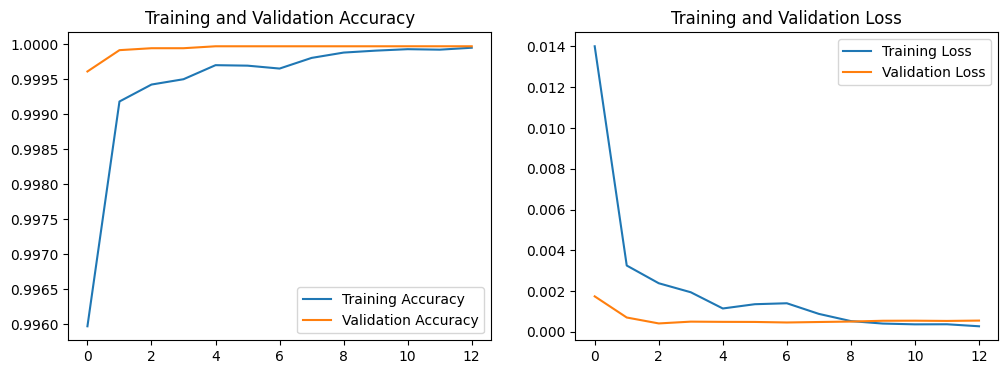

{'classification_report': '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     19405\n           1       1.00      1.00      1.00     25744\n\n    accuracy                           1.00     45149\n   macro avg       1.00      1.00      1.00     45149\nweighted avg       1.00      1.00      1.00     45149\n', 'confusion_matrix': array([[19398,     7],
       [    1, 25743]]), 'accuracy': 0.9998228089215708}


In [10]:
# Train Deep Learning Model
print("\nTraining Deep Learning Model...")
dl_results = ddos_analysis.deep_learning_model()
print(dl_results)

In [11]:
results_list = []

results_list.append({
    'Model': 'Deep Learning Model',
    'Accuracy': dl_results['accuracy'],
    'Confusion Matrix': dl_results['confusion_matrix']
})

results_df = pd.DataFrame(results_list)

print("Model Performance Summary:")
print(results_df)

print("\nDeep Learning Model Classification Report:")
print(dl_results['classification_report'])
print("-" * 50)

print("\nDeep Learning Model Confusion Matrix:")
conf_matrix = dl_results['confusion_matrix']
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted 0', 'Predicted 1'], 
                              index=['Actual 0', 'Actual 1'])
print(conf_matrix_df)
print("-" * 50)

Model Performance Summary:
                 Model  Accuracy          Confusion Matrix
0  Deep Learning Model  0.999823  [[19398, 7], [1, 25743]]

Deep Learning Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19405
           1       1.00      1.00      1.00     25744

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149

--------------------------------------------------

Deep Learning Model Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0        19398            7
Actual 1            1        25743
--------------------------------------------------
